In [ ]:
# ..... coexpression conservation across species? ..... #

In [4]:
library(Seurat)
library(dplyr)

In [2]:
get_top_pairs_mat <- function (mat.rank, n){ 
  f = mat.rank>dim(mat.rank)[1]-n
  mat.pairs = mat.rank*0
  mat.pairs[f] = 1
  return(mat.pairs)
}    

auroc_analytic2 <-function (mat, np, nL) { 
  ranks = 1:nL
  mini = sum(ranks[1:np])
  maxi = sum(ranks[(nL-np+1):nL])    
  range = maxi - mini    
  auroc <- (mat - mini)/range
  return(auroc)
}

roc_bg_predict <- function (bg_predict_res, species1, species2, np, nL){
  rocs = matrix(0, ncol = 2, nrow = dim(bg_predict_res[[1]])[2])
  colnames(rocs) = c(species1,species2)
  #   rownames(rocs) = rownames(bg_predict_res[[1]])
  
  ranks = 1:nL
  mini = sum(ranks[1:np])
  maxi = sum(ranks[(nL-np+1):nL])    
  range = maxi - mini
  
  for(i in 1:2){
    temp = t(apply(bg_predict_res[[i]], 1, function(x) rank(x, ties.method = "average")))        
    rocs[,i] <- (diag(temp) - mini)/range       
  }
  return(rocs)
}

In [6]:
spelist = c('turtle', 'chicken', 'mouse', 'human', 'wfrog', 'zebrafish')
dir0 = c('turtle', 'chicken', rep('other_species', 4))
fil0 = c('stage21', 'stage32', 'mouse', 'human', 'wfrog', 'zebrafish')

In [36]:
combos  = combn(1:length(spelist),2)
combn(spelist,2)

[,1]    [,2]   [,3]   [,4]   [,5]      [,6]    [,7]    [,8]    [,9]     
[1,] turtle  turtle turtle turtle turtle    chicken chicken chicken chicken  
[2,] chicken mouse  human  wfrog  zebrafish mouse   human   wfrog   zebrafish
     [,10] [,11] [,12]     [,13] [,14]     [,15]    
[1,] mouse mouse mouse     human human     wfrog    
[2,] human wfrog zebrafish wfrog zebrafish zebrafish

In [53]:
runid = 12
id1 = combos[1,runid]
id2 = combos[2,runid]

load(paste0(dir0[id1], '/', fil0[id1], '_sample_aggregate_top6000.Rdata'))
diag(aggNet) = 0
coexp_species1 = aggNet 

load(paste0(dir0[id2], '/', fil0[id2], '_sample_aggregate_top6000.Rdata'))
diag(aggNet) = 0
coexp_species2 = aggNet 


# load list of orthologs
file1 = paste0('other_species/', spelist[id1], '_', spelist[id2], '_orthologs_biomart.txt')
file2 = paste0('other_species/', spelist[id2], '_', spelist[id1], '_orthologs_biomart.txt')

if(file.exists(file1)){
    om = read.delim(file1, sep = '\t')
}else{
    om = read.delim(file2, sep = '\t')
    temp = om
    om[,1] <- temp[,2]
    om[,2] <- temp[,1]
}

colnames(om)[4] <- 'homology_type'
om <- om[om[,1]!='' & om[,2]!='' & om$homology_type=='ortholog_one2one',]
dim(om)
om[1,]


# rename other-species data gene names
rownames(coexp_species2) <- om[match(rownames(coexp_species2), om[,2]),1]
colnames(coexp_species2) = rownames(coexp_species2)
keepids = which(!is.na(rownames(coexp_species2)))
coexp_species2 <- coexp_species2[keepids,keepids]
dim(coexp_species2)

# subset to common orthologs
common_genes = intersect(rownames(coexp_species1), rownames(coexp_species2))
length(common_genes)
coexp_species1 <- coexp_species1[common_genes,common_genes]
coexp_species2 <- coexp_species2[common_genes,common_genes]


# calculate ranks and top 10s
rank_species1 = apply(coexp_species1, 1, rank, ties.method = 'average')
rank_species2 = apply(coexp_species2, 1, rank, ties.method = 'average')

mat1 = get_top_pairs_mat(t(rank_species1), 10)
mat2 = get_top_pairs_mat(t(rank_species2), 10)

gg_sp12 = mat1%*%rank_species2    # sp1 genes predict sp2 genes this well
gg_sp21 = mat2%*%rank_species1    # sp2 genes predict sp1 genes this well

res.mat1 = auroc_analytic2(gg_sp12, 10, dim(mat1)[2])
res.mat2 = auroc_analytic2(gg_sp21, 10, dim(mat2)[2])
res = vector("list", length = 2)
res[[1]] = res.mat1
res[[2]] = res.mat2


# function conservation and specificity scores #
fncons_aurocs = matrix(0, ncol = 2, nrow = dim(res[[1]])[2])
colnames(fncons_aurocs) = c(spelist[id2], spelist[id1])
fncons_aurocs[,1] = diag(res.mat1)
fncons_aurocs[,2] = diag(res.mat2)

spec_aurocs = roc_bg_predict(res, spelist[id2], spelist[id1], 1, dim(mat1)[1])

geneList = cbind(rownames(coexp_species1), rownames(coexp_species2))
colnames(geneList) = c(spelist[id1], spelist[id2])

roc_scores = data.frame(geneList, rowMeans(fncons_aurocs), rowMeans(spec_aurocs))
colnames(roc_scores) <- c('sp1_gene', 'sp2_gene', 'fc', 'sc')

# save
fileo = paste0(spelist[id1], '_', spelist[id2], '_singlecell_coexp_cons.csv')
write.table(roc_scores, file = fileo, sep = ',', row.names = F, col.names = T, quote = F)

[1] 8819    5

Gene.name Zebrafish.gene.name Last.common.ancestor.with.Zebrafish
6 mt-Nd1    mt-nd1              Vertebrata                         
  homology_type    Zebrafish.orthology.confidence..0.low..1.high.
6 ortholog_one2one 1

[1] 2439 2439

[1] 965

[1] 965   4

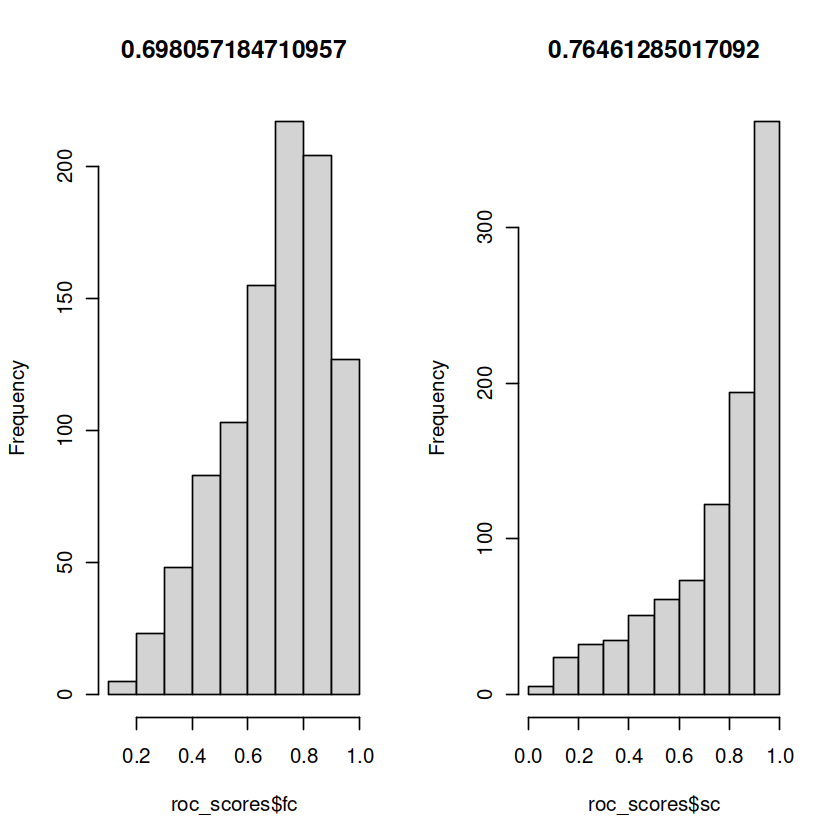

In [54]:
dim(roc_scores)
par(mfrow=c(1,2))
hist(roc_scores$fc, main = mean(roc_scores$fc, na.rm = T))
hist(roc_scores$sc, main = mean(roc_scores$sc, na.rm = T))

In [68]:
roc_scores[grep('Tbx1', roc_scores[,1]),]

sp1_gene sp2_gene fc        sc       
32  Tbx15    Tbx15    0.9349215 0.9738071
845 Tbx1     Tbx1     0.8751832 0.9662863